In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sbn
from mlxtend.data import loadlocal_mnist
from sklearn.metrics import roc_curve

In [22]:
def readData():
    ''' Used to read the data from ubyte format file into numpy array
        return four numpy arrays : (X_train, Y_train) - training dataset , (X_test, Y_test) - testing dataset
    '''
    X_train, Y_train = loadlocal_mnist(images_path='./data/train-images-idx3-ubyte', labels_path='./data/train-labels-idx1-ubyte')
    X_test, Y_test = loadlocal_mnist(images_path='./data/t10k-images-idx3-ubyte', labels_path='./data/t10k-labels-idx1-ubyte')
    return X_train, X_test, Y_train, Y_test

In [23]:
def loadAndProcessData():
    ''' This function is calls the readData() internally to read the data and extract the data related to trousrs and pullovers from it. It then processes 
        it : i)It binarizes the input image pixel values to 0 and 255 (ii) It also transforms the outcome to the values (0,1) from (1,2) with 1 value mapping to 0
        and 2 mapping to 1 respectively for easier handling.It also converts the input image data to desired column vector format by taking its transpose.
        Input parameter : No input parameters.
        Return value : returns four numpy arrays in the order : X_train-Input Image Training Data, X_test-Input image testing data, 
                        Y_train-output labels training data, Y_test-output label testing data
    '''

    X_train, X_test, Y_train, Y_test = readData() #reads the FMNIST dataset
    tnp_indices_train = np.where((Y_train == 1) | (Y_train == 2)) #Finds the indices corresponding to pullovers(2) and trousers(1) in the training labels dataset.
    tnp_indices_test = np.where((Y_test == 1) | (Y_test == 2)) #Finds the indices corresponding to pullovers(2) and trousers(1) in the testing labels dataset

    Y_train = Y_train[tnp_indices_train] #extract the label values corresponding to only trousers and pullovers from training label dataset
    X_train = X_train[tnp_indices_train] #extract the input image data corresponding to only trousers and pullovers from training image dataset
    Y_test = Y_test[tnp_indices_test] #extract the label values corresponding to only trousers and pullovers from testing label dataset
    X_test = X_test[tnp_indices_test] #extract the input image data corresponding to only trousers and pullovers from testing image dataset

    Y_train = Y_train - 1 #transforms the labels form values {1,2} to values {0,1} respectively
    Y_test = Y_test - 1 #transforms the labels form values {1,2} to values {0,1} respectively
    #the labels are form here on further in the whole code now are as follows : Trousers = 0 and Pullover = 1

    #The next part is used to binarize the input image dataset. The threshold chosen is the pixel value 128
    train_to_zero = np.where(X_train < 128) #Finding the coordinates in the input image training dataset that have pixel value less than 128
    train_to_max = np.where(X_train >= 128) #Finding the coordinates in the input image training dataset that have pixel value more than or equal to 128
    test_to_zero = np.where(X_test < 128) #Finding the coordinates in the input image testing dataset that have pixel value less than 128
    test_to_max = np.where(X_test >= 128) #Finding the coordinates in the input image testing dataset that have pixel value more than or equal to 128

    #The pixels values that are less than 128 in the training and testing dataset are mapped to 0 and those that are greater or equal to 128 are mapped to 255.This is done to binarize the input image data
    X_train[train_to_zero] = 0
    X_train[train_to_max] = 255
    X_test[test_to_zero] = 0
    X_test[test_to_max] = 255

    #reshaping both input image dataset and label data to my desired format
    Y_train = Y_train.reshape((1, Y_train.shape[0]))
    Y_test = Y_test.reshape((1, Y_test.shape[0]))

    X_train = np.transpose(X_train)
    X_test = np.transpose(X_test)

    #converting it to float type for further calculations
    X_train = X_train.astype(np.float64)
    X_test = X_test.astype(np.float64)


    return X_train, X_test, Y_train, Y_test

In [24]:
def getProbability(X, Y):
    ''' This function calculates the probabilites for each feature.For each feature it computes four values that are : P(x=0|y=0), P(x=255|y=0), P(x=0|y=1), P(x=255|y=1) where 'x' is the pixel value in that feature and y is the label value associated to it.
        Input : Two numpy format ndarrays: X - (NxM) size representing the input image dataset. Y - (1xM) size representing the label values associated with each input sample.
                Here M-no. of samples, N-no.of features. In the input, each row represents a feature and each column represents a particular sample.
        Return : It returns a two-dimensional numpy array of size (N x 4) where N are the number of features(here 784).For each feature 'k', the k^th row in the return array represents the probability calculations for that feature.
                The first column stores the value corresponding to input image pixel value 0 and label 0, the second column to image pixel 255 and label 0, third to image pixel 0 and label 1, fourth to image pixel 255 and label 1

    '''
    label_zero = np.where(Y == 0)[1] #find all indices in the output label datase where the label value is zero
    label_one = np.where(Y == 1)[1] #find all indices in the output label datase where the label value is one

    num_features = X.shape[0] #calculating the total number of features

    X_label_zero = X[:, label_zero] #extracting all those samples that correspond to label value zero
    X_label_one = X[:, label_one] #extracting all those samples that correspond to label value one

    probabs = np.zeros((num_features, 4)).astype(np.float64) #Intiallizing the probability storing matrix. Its columns are as follows : col1 = p(x=0|y=0),col2=p(x=255|y=0), col3=p(x=0|y=1)#col4=p(x=255|y=1) with x being the pixel value in input image dataset and y being the corresponding label value
    num_label_zero = X_label_zero.shape[1]
    num_label_one = X_label_one.shape[1]
    for i in range(num_features):

        num_zero_label_zero = np.count_nonzero(X_label_zero[i] == 0) #Counting all such cells in a particular feature that have pixel value 0 and have output label value for its sample as 0
        num_max_label_zero = np.count_nonzero(X_label_zero[i] == 255) #Counting all such cells in a particular feature that have pixel value 255 and have output label value for its sample as 0
        num_zero_label_one = np.count_nonzero(X_label_one[i] == 0) #Counting all such cells in a particular feature that have pixel value 0 and have output label value for its sample as 1
        num_max_label_one = np.count_nonzero(X_label_one[i] == 255) #Counting all such cells in a particular feature that have pixel value 255 and have output label value for its sample as 1


        probabs[i, 0] = (num_zero_label_zero + 1) / (num_label_zero + 2) #corresponds to P(x=0|y=0) for the i^th feature
        probabs[i, 1] = (num_max_label_zero + 1) / (num_label_zero + 2) #corresponds to P(x=255|y=0) for the i^th feature
        probabs[i, 2] = (num_zero_label_one + 1) / (num_label_one + 2) #corresponds to P(x=0|y=1) for the i^th feature
        probabs[i, 3] = (num_max_label_one + 1) / (num_label_one + 2) #corresponds to P(x=255|y=1) for the i^th feature

    probabs = np.log(probabs) #because the probability values can get very small while we will multiply them later, we store their log value instead of the direct value. LAter on instead of multiplying the probability values, we will add their log values so as to avoid any underflow issues for value being too small(tending to zero)
    
    return probabs

In [25]:
def getPriorProbab(Y):
    ''' This function is used to calculate the prior probability values. This is simply the probability of the label being zero or one irrespective of the corresponding input image smaple data.
        Input parameters : Numpy array containing the label values.
        Return value : p_label_zero - Probability of the output label being zero P(y=0), p_label_one - Probaibility of the output label being one P(y=1)
    '''
    num_total_Y = Y.shape[1] #the total number of samples in Y
    num_label_zeros = np.count_nonzero(Y == 0) #counting the number of samples that have label values zero
    num_label_ones = np.count_nonzero(Y == 1) #counting the number of samples that have label values one

    p_label_zero = float(num_label_zeros) / float(num_total_Y) #calculating the probability of the output label being zero
    p_label_one = float(num_label_ones) / float(num_total_Y) #calculating the probability of the output label being one

    return p_label_zero, p_label_one

In [26]:
def findSampleProbability(x, probabilities):
    ''' This functions finds the posterior probability given a particular input sample 'x'.
        Input parameters: x - A particular sample value (1xN) where N=no. of features, probabilities-The (Nx4) numpy matrix built for the training set using getProbability(X,Y) function that has all the log probabilities calculated for the features in the training set.
        Return value : log_probab_zero - The logarithm of probability of the output label being zero given the input sample, log_probab_one - The logarithm of probability of the output label being one given the input sample
    '''
    log_probab_one = 0
    log_probab_zero = 0
    for k in range(x.shape[1]):  #iterate over all the feature values for the particular sample
        if(x[0, k] == 0): #if the pixel value for the k^th feature is zero
            log_probab_one += probabilities[k, 2] # add log value of P(x=0|y=1) which is the value at third column in the 'probabilities' matrix
            log_probab_zero += probabilities[k, 0] # add log value of P(x=0|y=0) which is the value at first column in the 'probabilities' matrix
        elif(x[0, k] == 255): #if the pixel value for the k^th feature is 255
            log_probab_one += probabilities[k, 3] # add log value of P(x=255|y=1) which is the value at fourth column in the 'probabilities' matrix
            log_probab_zero += probabilities[k, 1] # add log value of P(x=255|y=0) which is the value at second column in the 'probabilities' matrix
    return log_probab_zero, log_probab_one


In [27]:
def trainNaiveBayes(X_train, Y_train):
    ''' Function for training the naive bayes classifier.Calculates the (N x 4) (N=no. of features) matrix of log of conditional probability values for each 
        feature for the training dataset.Also, calculates the prior probabilities for the training output label dataset.
        Input parameter : (X_train, Y_train) the training dataset
        Return value : returns the computed Nx4 matrix, and the prior probabilities.
    '''
    probabilities = getProbability(X_train, Y_train)
    prior_probab_zero, prior_probab_one = getPriorProbab(Y_train)
    return probabilities, prior_probab_zero, prior_probab_one

In [28]:
def predictNaiveBayes(X_test, probabilities, prior_probab_zero, prior_probab_one):
    ''' This function is used to calculate the predictions for a particular input testing dataset.
        Input parameters: X_test-testing input image dataset, probabilities-The (Nx4) numpy matrix built for the training set using getProbability(X,Y) function that has all the 
        log probabilities calculated for the features in the training set, (prior_probab_zero, prior_probab_one) - the prior probabilities of output label being zero or one.
        Return values: A (1xM) numpy matrix containing the predicted output label for each of the sample in the input image testing dataset. (m=no. of samples in the input image dataset X_test)
    '''
    predict_probab_one = np.zeros((1, X_test.shape[1]))
    predict_probab_zero = np.zeros((1, X_test.shape[1]))
    final_prediction = np.zeros((1, X_test.shape[1]))
    for col in range(X_test.shape[1]): #iterating over the samples one by one
        x_sample = X_test[:, col].reshape((1, X_test.shape[0])) #reshaping the sample for using it to calculate the posterior probability
        p_zero, p_one = findSampleProbability(x_sample, probabilities) #calculating the posterior probability
        predict_probab_zero[0][col] = p_zero + np.log(prior_probab_zero) #adding log of prior probability 
        predict_probab_one[0][col] = p_one + np.log(prior_probab_one) #adding log of prior probability
        if(predict_probab_zero[0][col] <= predict_probab_one[0][col]):
            final_prediction[0][col] = 1
    
    return final_prediction

Q3 (C) confusion MAtrix, Metrics and ROC Curve (Doing here because I will be using it while testing my Naive Bayes)

In [29]:
def calculateConfusionMatrix(prediction_values, actual_values):
    ''' The function is used to calculate the confusion matrix for the given model's predictions.
        Input : prediction_values : numpy ndarray containing predicted values for a particular input feature datatset, actual_values - corresponding actual label values
        Returns : confusion matrix : A 2x2 confusion matrix
    '''
    confusion_matrix = np.zeros((2, 2))
    Y_predicted = (np.round(prediction_values)).reshape((prediction_values.shape[1],))
    Y_actual = (actual_values).reshape((actual_values.shape[1],))
    confusion_matrix[0, 0] = np.sum((Y_predicted == Y_actual) & (Y_actual == 1)) #TP 
    confusion_matrix[0, 1] = np.sum((Y_predicted != Y_actual) & (Y_actual == 0)) #FP
    confusion_matrix[1, 0] = np.sum((Y_predicted != Y_actual) & (Y_actual == 1)) #FN
    confusion_matrix[1, 1] = np.sum((Y_predicted == Y_actual) & (Y_actual == 0)) #TN

    return confusion_matrix

In [30]:
def calculateMetrics(conf_matrix):
    ''' The function is used to calculate all the four model performance stats which includes accuracy, precision, recall, f1_score
        Input : conf_matrix : a 2x2 confusion matrix
        Returns : Three floating point values accuracy, precision, recall respectively.
    '''
    true_pos = conf_matrix[1, 1]
    true_neg = conf_matrix[0, 0]
    false_pos = conf_matrix[0, 1]
    false_neg = conf_matrix[1, 0]
    accuracy = (float(true_pos + true_neg)) / (float(true_pos + true_neg + false_pos + false_neg))
    precision = (float(true_pos)) / (float(true_pos + false_pos))
    recall = (float(true_pos)) / (float(true_pos + false_neg))

    return accuracy, precision, recall

In [31]:
def plotConfusionMatrix(confusion_matrix):
    ''' this function is used to plot the confusion matrix
        Input: confusion_matrix : A 2x2 matrix representing confusion matrix 
    '''
    rot_conf_matrix = np.zeros((2,2))
    rot_conf_matrix[1, 1] = confusion_matrix[0, 0]
    rot_conf_matrix[0, 1] = confusion_matrix[0, 1]
    rot_conf_matrix[1, 0] = confusion_matrix[1, 0]
    rot_conf_matrix[0, 0] = confusion_matrix[1, 1]
    sbn.heatmap(rot_conf_matrix, annot=True, cmap='Blues')
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('Confusion Matrix')
    plt.show()

In [32]:
def plot_ROC_curve(prediction_val, Y_actual_test):
    '''This function is used to plot the ROC curve for the classifier given a particular predicted value and actual value set.
        Input : prediction_values : numpy ndarray containing predicted values for a particular input feature datatset, actual_values - corresponding true label values
    '''
    false_pos_rate, true_pos_rate, thresh = roc_curve(Y_actual_test.reshape((Y_actual_test.shape[1], )), prediction_val.reshape((prediction_val.shape[1], )), pos_label=1)
    plt.plot(false_pos_rate, true_pos_rate, color='blue')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.show()

Naive Bayes
Accuracy : 0.933
Precision : 0.964
Recall : 0.9077212806026366



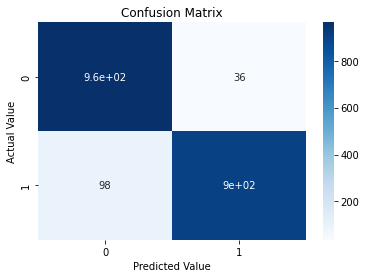

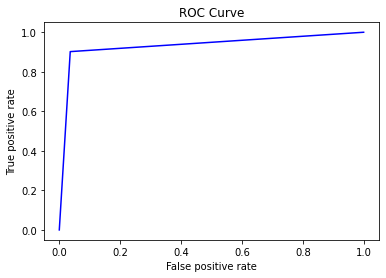

In [33]:
# A block to check the working of the Naive Bayes classifier.

X_train, X_test, Y_train, Y_test = loadAndProcessData() #load and process the dataset and get the training and testing dataset.
probabilities, prior_zero, prior_one = trainNaiveBayes(X_train, Y_train) #traing the niave bayes classifier on the training dataset.

prediction_values = predictNaiveBayes(X_test, probabilities, prior_zero, prior_one) #calculate predictions using the classifier on the given testing set image input values.

confusion_matrix_test = calculateConfusionMatrix(prediction_values, Y_test) #calculate the confusion matrix
accuracy_test, precision_test, recall_test = calculateMetrics(confusion_matrix_test) #calculate the accuracy, precision and recall
print(f'Naive Bayes\nAccuracy : {accuracy_test}\nPrecision : {precision_test}\nRecall : {recall_test}\n')
plotConfusionMatrix(confusion_matrix_test) #plotting the confusion matrix
plot_ROC_curve(prediction_values, Y_test) #plotting the roc curve

Q3 (B) K-Fold Cross-Validation

Fold iteration : 1 / 5



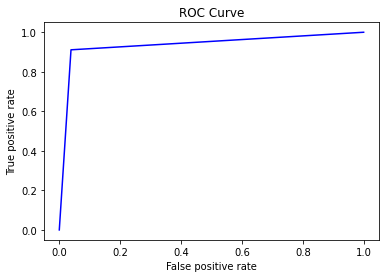

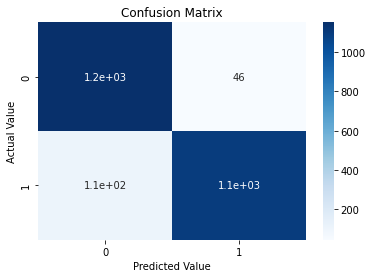


Accuracy : 0.93625
Precision : 0.9615384615384616
Recall : 0.9148766905330151

Fold iteration : 2 / 5



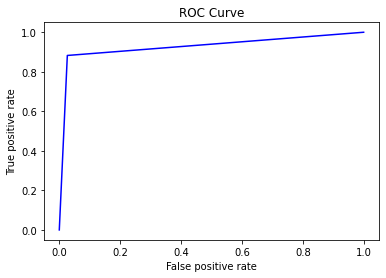

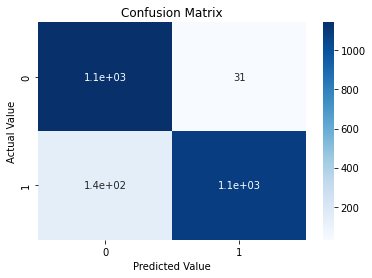


Accuracy : 0.9270833333333334
Precision : 0.9735945485519591
Recall : 0.8881118881118881

Fold iteration : 3 / 5



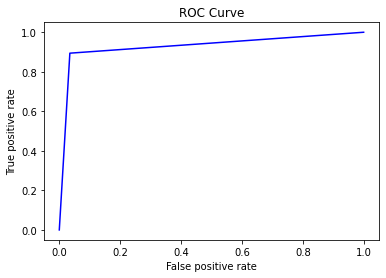

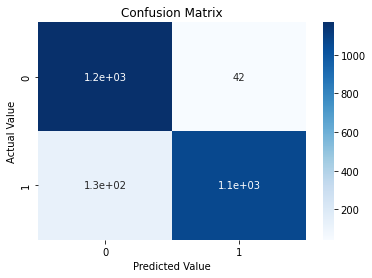


Accuracy : 0.93
Precision : 0.9652892561983472
Recall : 0.9026275115919629

Fold iteration : 4 / 5



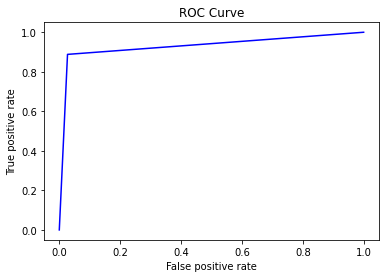

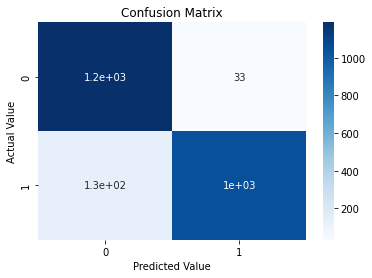


Accuracy : 0.93125
Precision : 0.972972972972973
Recall : 0.9

Fold iteration : 5 / 5



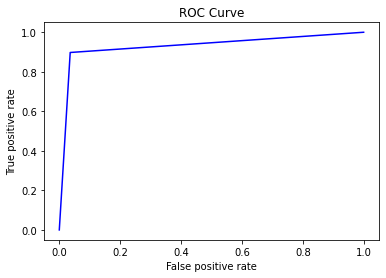

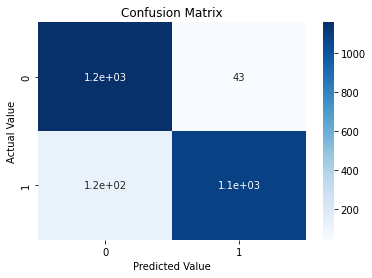


Accuracy : 0.9308333333333333
Precision : 0.9641367806505421
Recall : 0.9038311180609852


***** k = 5 Mean Accuracy : 0.9310833333333333   *****



In [34]:
def split_into_k_folds(kf_X_train,kf_Y_train, k):
    ''' This function is used to divide the training set into k separate batches. It shuffles the dataset randomly and then splits it into k batches.
        Input parameter: (kf_X_train, kf_Y_train)-training dataset. k-the no. of batches
        Return value : Two lists X_fold: contains k items that are the k batches input image data is divided into, Y_folds: contains k items that are the k batches output label data is divided into
    '''

    M = kf_X_train.shape[1]
    #shuffling the array by generating a random permutation
    shuffledPermutation = np.random.permutation(M)
    shuff_kf_X_train = kf_X_train[:, shuffledPermutation]
    shuff_kf_Y_train = kf_Y_train[:, shuffledPermutation]

    num_sample = shuff_kf_X_train.shape[1]
    
    fold_size = int(num_sample / k) #calculating the size of one group
    X_folds = [] #a list to hold the k groups of the input image dataset
    Y_folds = [] #a list to hold the k groups of the output label dataset
    lo = 0
    while(lo + fold_size - 1 < num_sample): #loop to divide the data set into k groups
        X_fold_i = shuff_kf_X_train[:, [x for x in range(lo, lo + fold_size)]] #finding the samples that will go into this group
        Y_fold_i = shuff_kf_Y_train[:, [x for x in range(lo, lo + fold_size)]] #finding the samples that will go into this group
        X_folds.append(X_fold_i)
        Y_folds.append(Y_fold_i)
        lo += fold_size
    return X_folds, Y_folds

def perform_K_cross_val(kf_X_train, kf_Y_train, k):
    ''' This function performs the k-fold cross validation. It calls the split_into_k_folds() function internally to split the dataset into k batches. It then iterates and 
        for each unique batch, it takes that out to be the validation set(from both X_folds and Y_folds) and combines the rest k-1 batches to form the training data set. A new Naive bayes classifier
        model is trained on the training set and the scores(Accuracy, precision, recall), ROC are calculated for each iteration of the same. The mean accuracy is reported at the end.
        Input parameter : (kf_X_train, kf_Y_train)-training dataset. k-the no. of batches
        Return value: The mean accuracy.

    '''
    X_folds, Y_folds = split_into_k_folds(kf_X_train, kf_Y_train, k) #splitting the dataset into k batches
    val_accuracies = [] #A list to hold the accuracies calculated at each iteration (when one group is chosen as validation and others as training)
    for i in range(k):
        X_val_fold = X_folds[i] #choosing one batch as validation set
        Y_val_fold = Y_folds[i] #choosing one batch as validation set
        X_train_fold = np.concatenate((X_folds[:i] + X_folds[i + 1:]), axis=1) #combining the rest k-1 batches to form training set
        Y_train_fold = np.concatenate((Y_folds[:i] + Y_folds[i + 1:]), axis=1)  #combining the rest k-1 batches to form training set
        kf_prob_train, kf_prior_zero, kf_prior_one = trainNaiveBayes(X_train_fold, Y_train_fold) #train the model on the training batch
        kf_predict = predictNaiveBayes(X_val_fold, kf_prob_train, kf_prior_zero, kf_prior_one) #compute predicition on validation batch
        kf_confusion_matrix = calculateConfusionMatrix(kf_predict, Y_val_fold) #fnding confusion matrix 
        accuracy_val, precision_val, recall_val = calculateMetrics(kf_confusion_matrix) #calculating the accuracy, precision and recall
        print(f'Fold iteration : {i + 1} / {k}\n')
        plot_ROC_curve(kf_predict, Y_val_fold) #plotting roc curve
        plotConfusionMatrix(kf_confusion_matrix) #plotting confusion matrix
        print(f'\nAccuracy : {accuracy_val}\nPrecision : {precision_val}\nRecall : {recall_val}\n')
        val_accuracies.append(accuracy_val)
    
    mean_accuracy = np.mean(val_accuracies) #finding the mean accuracy
    return mean_accuracy

k_val = 5
mean_acc = perform_K_cross_val(X_train, Y_train, k_val) #performing k-fold cross validation
print(f'\n***** k = {k_val} Mean Accuracy : {mean_acc}   *****\n')

On a side-note : I also tried this questions without binarizing the images and making the input discrete and therefore by taking the input as continuous distribution and applied Gaussian Naive Bayes to the same.Following is my attempt for the same.

In [35]:
def gauss_loadAndProcessData():
    ''' This function is used to read(load) and process the data before using it to train our model.It transforms the outcome to the values (0,1) from (1,2) with 1 value mapping to 0
        and 2 mapping to 1 respectively for easier handling.It also converts the input image data to desired column vector format by taking its transpose.
        Input parameter : No input parameters.
        Return value : returns four numpy arrays in the order : gauss_X_train-Input Image Training Data, gauss_X_test-Input image testing data, gauss_Y_train-output labels training data, gauss_Y_test-output label testing data'''
    gauss_X_train, gauss_X_test, gauss_Y_train, gauss_Y_test = readData() #reads the FMNIST dataset
    tnp_indices_train = np.where((gauss_Y_train == 1) | (gauss_Y_train == 2)) #Finds the indices corresponding to pullovers(2) and trousers(1) in the training labels dataset.
    tnp_indices_test = np.where((gauss_Y_test == 1) | (gauss_Y_test == 2)) #Finds the indices corresponding to pullovers(2) and trousers(1) in the testing labels dataset
    gauss_Y_train = gauss_Y_train[tnp_indices_train] #extract the label values corresponding to only trousers and pullovers from training label dataset
    gauss_X_train = gauss_X_train[tnp_indices_train] #extract the input image data corresponding to only trousers and pullovers from training image dataset
    gauss_Y_test = gauss_Y_test[tnp_indices_test] #extract the label values corresponding to only trousers and pullovers from testing label dataset
    gauss_X_test = gauss_X_test[tnp_indices_test] #extract the input image data corresponding to only trousers and pullovers from testing image dataset
    gauss_Y_train = gauss_Y_train - 1 #transforms the labels form values {1,2} to values {0,1} respectively
    gauss_Y_test = gauss_Y_test - 1
    #the labels are form here on further in the whole code now are as follows : Trousers = 0 and Pullover = 1

    #reshaping both input image dataset and label data to my desired format
    gauss_Y_train = gauss_Y_train.reshape((1, gauss_Y_train.shape[0]))
    gauss_Y_test = gauss_Y_test.reshape((1, gauss_Y_test.shape[0]))
    gauss_X_train = np.transpose(gauss_X_train)
    gauss_X_test = np.transpose(gauss_X_test)


    return gauss_X_train, gauss_X_test, gauss_Y_train, gauss_Y_test

In [36]:
def gauss_getProbability(X, label_mean, label_var):
    ''' This function calculates the log of probability(conditional) of the features for a given X matrix of samples. Given a particular value mena and variance values for every feature depending upon the output label.
    '''
    gauss_log_probab = -1 * ((np.log(np.sqrt(label_var))) + (np.log(2 * np.pi) / 2) + (np.square(X - label_mean) / (2 * np.sqrt(label_var))) ) #log of the formula of probability for a gaussian distribution
    return gauss_log_probab

In [37]:
def gauss_getMeanVarByLabel(X, Y):
    ''' Calculate the mean and variance of the features depending on the output label(0 or 1).It returns four numpy arrays denoting the means and variances respectively given the output label value zero and one respectively.
    '''
    label_ones = np.where(Y == 1)[1] #find all indices in the output label datase where the label value is one
    label_zeros = np.where(Y == 0)[1] #find all indices in the output label datase where the label value is zero
    X_label_zeros = X[:, label_zeros] #extracting all those samples that correspond to label value zero
    X_label_ones = X[:, label_ones] #extracting all those samples that correspond to label value one

    num_features = X.shape[0]

    #calculating means based on label value
    mean_ones = (np.mean(X_label_ones, axis=1).reshape((num_features, 1))).astype(np.float64) 
    mean_zeros =(np.mean(X_label_zeros, axis=1).reshape((num_features, 1))).astype(np.float64)

    #calculating variance based on label values
    var_ones = (np.var(X_label_ones, axis=1).reshape((num_features, 1))).astype(np.float64)
    var_zeros = (np.var(X_label_zeros, axis=1).reshape((num_features, 1))).astype(np.float64)

    return mean_zeros, mean_ones, var_zeros, var_ones


In [38]:
def gauss_getPriorProbab(Y):
    ''' This function is used to calculate the prior probability values. This is simply the probability of the label being zero or one irrespective of the corresponding input image smaple data.
        Input parameters : Numpy array containing the label values.
        Return value : p_label_zero - Probability of the output label being zero P(y=0), p_label_one - Probaibility of the output label being one P(y=1)
    '''
    #it works in the exact same way as the one in the discrete case as above, just separated both functions for distinctness
    num_total_Y = Y.shape[1]
    num_label_zeros = np.count_nonzero(Y == 0)
    num_label_ones = np.count_nonzero(Y == 1)

    p_label_zero = float(num_label_zeros) / float(num_total_Y)
    p_label_one = float(num_label_ones) / float(num_total_Y)

    return p_label_zero, p_label_one

In [39]:
def gauss_naiveBayes(gauss_X_train, gauss_X_test, gauss_Y_train, gauss_Y_test):
    ''' This function trains the model on a particular training dataset and finds the prediction for the input testing set.It is a gaussian naive bayes classifier.
        Input params: (gauss_X_train, gauss_X_test)- training dataset , (gauss_Y_train, gauss_Y_test) - testing dataset
    '''
    gauss_prior_zero, gauss_prior_one = gauss_getPriorProbab(gauss_Y_train) #calculate the prior probabilities for training label dataset
    mean_zeros, mean_ones, var_zeros, var_ones = gauss_getMeanVarByLabel(gauss_X_train, gauss_Y_train) #calculting mean and variance for each feature depending on the label outcome

    #A step to make the size of the matrix compatible for using in a further function
    mean_zeros = np.concatenate((mean_zeros, np.tile(mean_zeros[:, 0].reshape(mean_zeros.shape[0], 1), gauss_Y_test.shape[1] - 1)), axis=1)
    mean_ones = np.concatenate((mean_ones, np.tile(mean_ones[:, 0].reshape(mean_ones.shape[0], 1), gauss_Y_test.shape[1] - 1)), axis=1)
    var_zeros = np.concatenate((var_zeros, np.tile(var_zeros[:, 0].reshape(var_zeros.shape[0], 1), gauss_Y_test.shape[1] - 1)), axis=1) 
    var_ones = np.concatenate((var_ones, np.tile(var_ones[:, 0].reshape(var_ones.shape[0], 1), gauss_Y_test.shape[1] - 1)), axis=1)

    var_ones[var_ones < 0.00001] = 0.00001 #if the variance is very low, make it to 10^(-5) to avoid division errors
    var_zeros[var_zeros < 0.00001] = 0.00001 #if the variance is very low, make it to 10^(-5) to avoid division errors
    gauss_probab_zeros = (np.sum(gauss_getProbability(gauss_X_test, mean_zeros, var_zeros), axis=0).reshape(gauss_X_test.shape[1], 1))  + np.log(gauss_prior_zero) #finding the posterior probability for output label being 0
    gauss_probab_ones = (np.sum(gauss_getProbability(gauss_X_test, mean_ones, var_ones), axis=0).reshape(gauss_X_test.shape[1], 1)) + np.log(gauss_prior_one) #finding the posterior probability for output label being 1

    comparison_array = np.concatenate([gauss_probab_zeros.reshape(1, gauss_probab_zeros.shape[0]), gauss_probab_ones.reshape(1, gauss_probab_ones.shape[0])],axis=0) #comparing them to find the predicition

    args = comparison_array.argmax(axis=0).reshape((1, comparison_array.shape[1])) #calculating prediciton value by comparing both of the calculated posterior probailities and taking the max of them 

    return args


Gaussian Naive Bayes
Accuracy : 0.969
Precision : 0.955
Recall : 0.9825102880658436



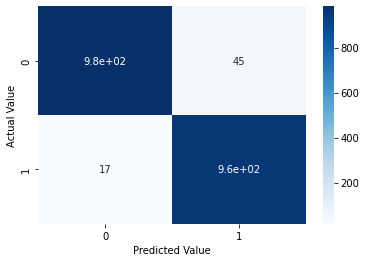

In [40]:
#A block of code to check the gaussian niave bayes classifier model 

gauss_X_train, gauss_X_test, gauss_Y_train, gauss_Y_test = gauss_loadAndProcessData()
gauss_predicted = gauss_naiveBayes(gauss_X_train, gauss_X_test, gauss_Y_train, gauss_Y_test)

gauss_confusion_matrix_test = calculateConfusionMatrix(gauss_predicted, gauss_Y_test)
gauss_accuracy_test, gauss_precision_test, gauss_recall_test = calculateMetrics(gauss_confusion_matrix_test)
sbn.heatmap(gauss_confusion_matrix_test, annot=True, cmap='Blues')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
print(f'Gaussian Naive Bayes\nAccuracy : {gauss_accuracy_test}\nPrecision : {gauss_precision_test}\nRecall : {gauss_recall_test}\n')

